In [1]:
import os
import pandas as pd
from zipfile import ZipFile

# Set up Kaggle API (ensure you have uploaded kaggle.json to /content/)
os.makedirs("~/.kaggle", exist_ok=True)
os.system("cp /content/kaggle.json ~/.kaggle/")
os.system("chmod 600 ~/.kaggle/kaggle.json")

# Function to download and extract dataset
def download_kaggle_dataset(dataset: str, extract_path: str = "datasets"):
    os.makedirs(extract_path, exist_ok=True)
    os.system(f"kaggle datasets download -d {dataset} -p {extract_path} --unzip")
    return extract_path

# Download datasets
download_kaggle_dataset("hadasu92/cnn-articles-after-basic-cleaning")
download_kaggle_dataset("gpreda/bbc-news")
download_kaggle_dataset("everydaycodings/global-news-dataset")

# Load datasets into DataFrames
cnn_articles_df = pd.read_csv("/content/datasets/CNN_Articels_clean/CNN_Articels_clean.csv")  # Adjust filename if needed
bbc_news_df = pd.read_csv("datasets/bbc_news.csv")  # Adjust filename if needed
global_news_df = pd.read_csv("/content/datasets/data.csv")  # Adjust filename if needed

In [2]:
import pandas as pd

# Load datasets into DataFrames
cnn_articles_df = pd.read_csv("/content/datasets/CNN_Articels_clean/CNN_Articels_clean.csv")  # Adjust filename if needed
bbc_news_df = pd.read_csv("datasets/bbc_news.csv")  # Adjust filename if needed
global_news_df = pd.read_csv("/content/datasets/data.csv")  # Adjust filename if needed

In [3]:
print("CNN Articles:")
print(cnn_articles_df.head())
print("\nBBC News:")
print(bbc_news_df.head())
print("\nGlobal News:")
print(global_news_df.head())

CNN Articles:
   Index                                             Author  \
0      0                                 Jacopo Prisco, CNN   
1      2                              Stephanie Bailey, CNN   
2      3  Words by Stephanie Bailey, video by Zahra Jamshed   
3      4                    Paul R. La Monica, CNN Business   
4      7                                            Reuters   

        Date published  Category    Section  \
0  2021-07-15 02:46:59      news      world   
1  2021-05-12 07:52:09      news      world   
2  2021-06-16 02:51:30      news       asia   
3  2022-03-15 09:57:36  business  investing   
4  2022-03-15 11:27:02  business   business   

                                                 Url  \
0  https://www.cnn.com/2021/07/14/world/tusimple-...   
1  https://www.cnn.com/2021/05/12/world/ironhand-...   
2  https://www.cnn.com/2021/06/15/asia/swarm-robo...   
3  https://www.cnn.com/2022/03/15/investing/brics...   
4  https://www.cnn.com/2022/03/15/business/r

In [3]:
cnn_articles_df = cnn_articles_df[['Date published','Headline', 'Description']]
global_news_df = global_news_df[['published_at', 'title', 'description']]
bbc_news_df = bbc_news_df[['pubDate', 'title', 'description']]
columns = ['date_published', 'headline', 'description']
cnn_articles_df.columns = columns
global_news_df.columns = columns
bbc_news_df.columns = columns

In [4]:
combined_df = pd.concat([cnn_articles_df, bbc_news_df, global_news_df], ignore_index=True)

In [ ]:
from langdetect import detect

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

# Apply the is_english function to both 'headline' and 'description' columns
combined_df = combined_df[combined_df['headline'].apply(is_english) & combined_df['description'].apply(is_english)]




#Analysis


            date_published                                           headline  \
65325                  NaT  Jewish institutions in the US are on guard fol...   
117160 2023-11-10 15:10:38  Montreal police probe shots fired at Jewish sc...   
27888                  NaT     Hate crimes in London see big jump, police say   
101719                 NaT  Reported hate crimes in several Canadian citie...   
84848                  NaT    Austria sees sharp rise in acts of antisemitism   
100462                 NaT  How Houthi Attacks Affect Both the Israel-Hama...   
60704                  NaT  Increase in harassment against Jewish, Muslim ...   
33491                  NaT  Jewish man told to leave Paul Currie gig says ...   
93797                  NaT  FBI investigating antisemitic threats to Corne...   
58733                  NaT  Harvard, Yale warned by top law firms about ca...   

                                              description  similarity_score  
65325   The Jewish Federations

<ipython-input-6-e7b9d5a6624e>:56: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  top_related_df.set_index('date_published').resample('M').size().plot()


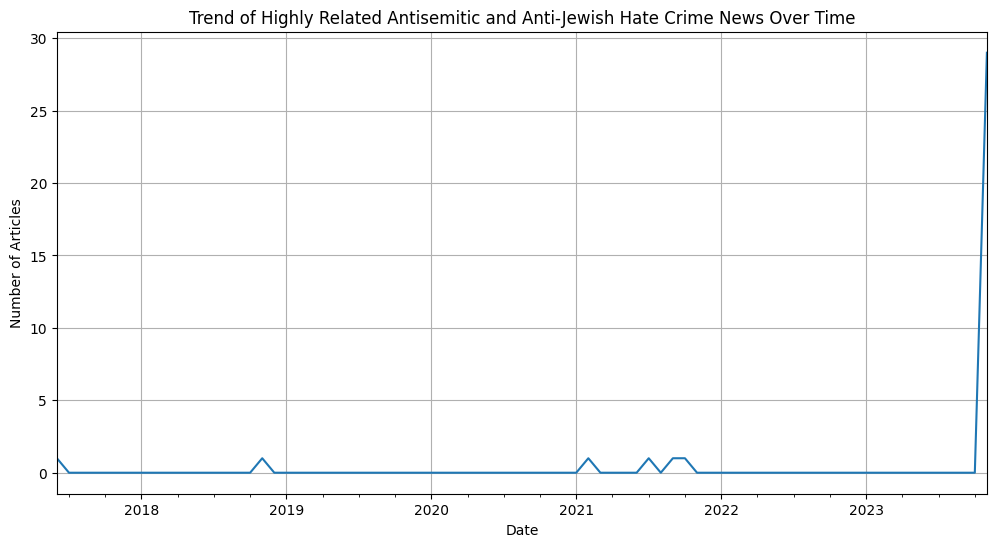

In [6]:
from sentence_transformers import SentenceTransformer, util
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gensim
import torch


# Convert date_published to datetime
combined_df['date_published'] = pd.to_datetime(combined_df['date_published'], errors='coerce')


# Load Sentence-BERT model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Define reference hate crime descriptions
reference_texts = [
    "An antisemitic attack occurred at a synagogue",
    "Jewish community targeted in hate crime",
    "Violence against Jewish people reported",
    "Jewish symbols vandalized in hate incident",
    "Threats made against Jewish individuals",
    "Physical assault on Jewish individuals due to religious hatred"
]

# Encode reference texts
reference_embeddings = model.encode(reference_texts, convert_to_tensor=True)

# Compute similarity scores for descriptions
combined_df = combined_df.dropna(subset=['description']).copy()
article_embeddings = model.encode(combined_df['description'].tolist(), convert_to_tensor=True)
similarities = util.pytorch_cos_sim(article_embeddings, reference_embeddings).max(dim=1).values
combined_df['similarity_score'] = similarities.cpu().numpy()

# Show top related articles
top_related = combined_df.nlargest(10, 'similarity_score')
print(top_related[['date_published', 'headline', 'description', 'similarity_score']])

# Filter based on similarity threshold
top_related_df = combined_df[combined_df['similarity_score'] > 0.5].copy()
top_related_df = top_related_df.dropna(subset=['date_published'])

# Plot number of relevant articles over time
plt.figure(figsize=(12, 6))
top_related_df.set_index('date_published').resample('M').size().plot()
plt.title("Trend of Highly Related Antisemitic and Anti-Jewish Hate Crime News Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import re
import time
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.extra.rate_limiter import RateLimiter

import geopy
from geopy.geocoders import Nominatim
import re
import time

# Initialize geolocator
geolocator = Nominatim(user_agent="geo_extractor")

# Function to extract location from text
def extract_location(text):
    if pd.isna(text):
        return None

    # Extract possible location mentions
    words = re.findall(r'\b[A-Z][a-z]+(?:\s[A-Z][a-z]+)*\b', text)
    for word in words:
        try:
            location = geolocator.geocode(word, timeout=10)
            if location:
              return location.address  # Return the full address
        except Exception as e:
            print(f"Error with {word}: {e}")
    return None

# Apply function to create a new column
top_related_df['event_location'] = top_related_df['headline'].fillna('') + ' ' + top_related_df['description'].fillna('')
top_related_df['event_location'] = top_related_df['event_location'].apply(extract_location)



In [ ]:
from google.colab import files

# Save DataFrame as CSV
combined_df.to_csv("news_data_parsed_with_locations.csv", index=False)

# Download the file
files.download("news_data_parsed_with_locations.csv")

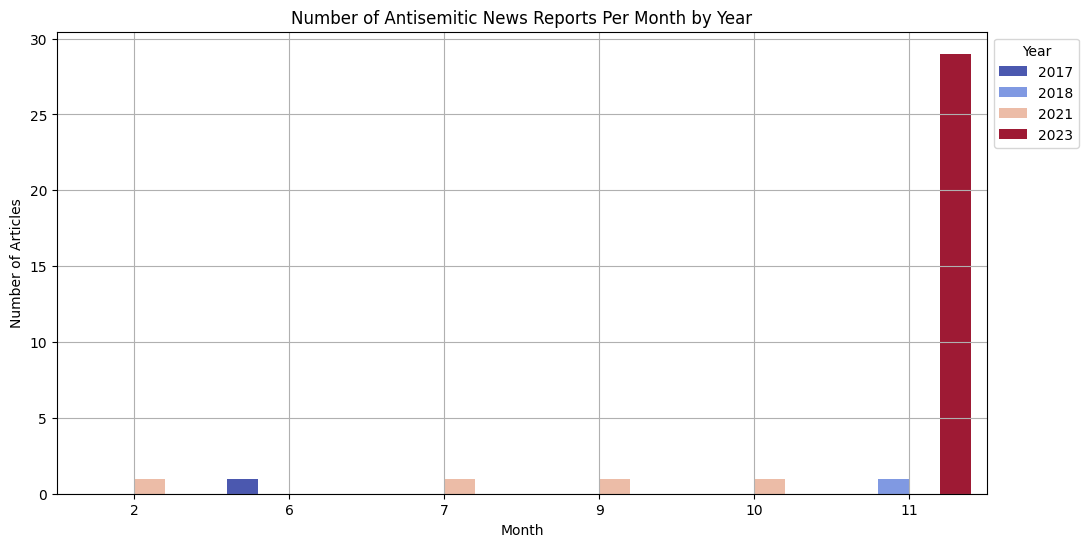

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import numpy as np
top_related_df['date_published'] = pd.to_datetime(top_related_df['date_published'], errors='coerce')

# Extract Year and Month for Grouping
top_related_df['year'] = top_related_df['date_published'].dt.year
top_related_df['month'] = top_related_df['date_published'].dt.month

# ---- 1. Barplot: Events Per Month by Year ----
plt.figure(figsize=(12, 6))
sns.countplot(data=top_related_df, x='month', hue='year', palette='coolwarm')
plt.title("Number of Antisemitic News Reports Per Month by Year")
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.legend(title="Year", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

Sanity check of similarity score distribution

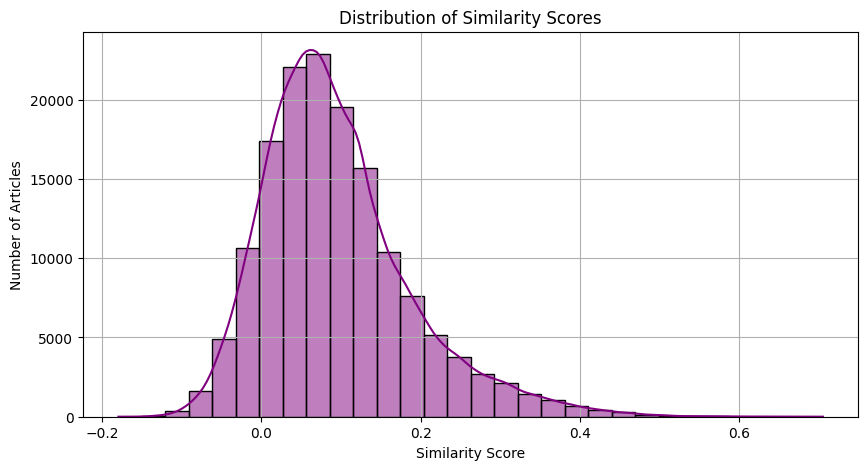

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(combined_df['similarity_score'].dropna(), bins=30, kde=True, color="purple")
plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.show()

General understanding of common words and nomenclature in news regarding hate crimes against jewish people and communities

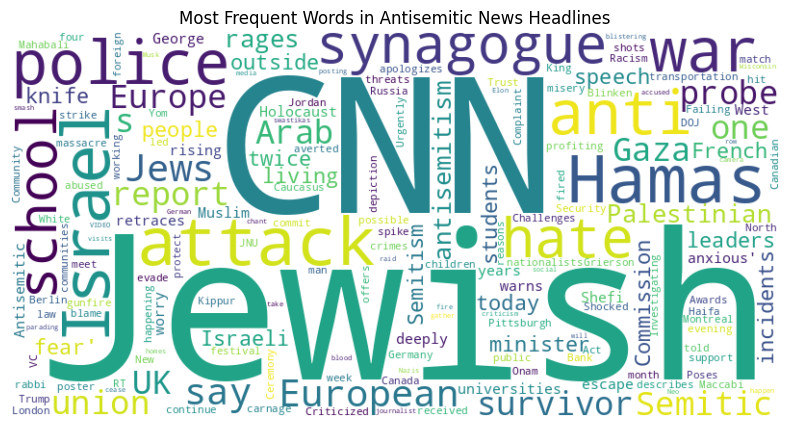

In [20]:
all_headlines = " ".join(top_related_df['headline'].dropna().astype(str).values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_headlines)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Antisemitic News Headlines")
plt.show()

<ipython-input-21-07cba24a35a5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pre_df, x="Count", y="Word", ax=ax[0], palette="Blues_r")
<ipython-input-21-07cba24a35a5>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=post_df, x="Count", y="Word", ax=ax[1], palette="Reds_r")


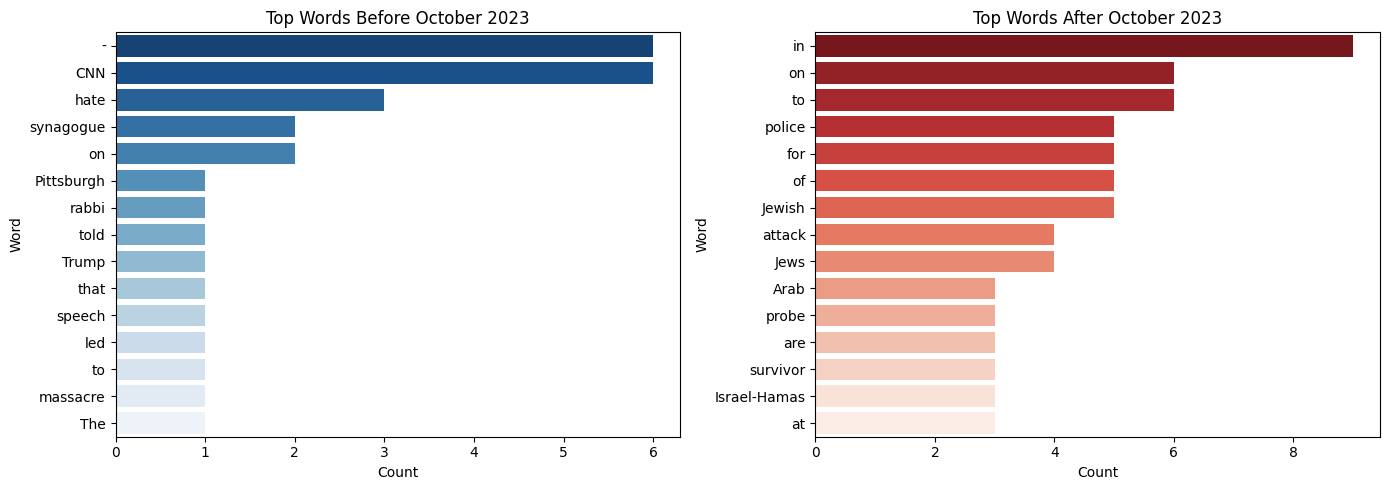

In [21]:
pre_october = top_related_df[top_related_df['date_published'] < '2023-10-07']
post_october = top_related_df[top_related_df['date_published'] >= '2023-10-07']

pre_words = Counter(" ".join(pre_october['headline'].dropna().astype(str).values).split()).most_common(15)
post_words = Counter(" ".join(post_october['headline'].dropna().astype(str).values).split()).most_common(15)

pre_df = pd.DataFrame(pre_words, columns=['Word', 'Count'])
post_df = pd.DataFrame(post_words, columns=['Word', 'Count'])

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=pre_df, x="Count", y="Word", ax=ax[0], palette="Blues_r")
ax[0].set_title("Top Words Before October 2023")

sns.barplot(data=post_df, x="Count", y="Word", ax=ax[1], palette="Reds_r")
ax[1].set_title("Top Words After October 2023")

plt.tight_layout()
plt.show()



<ipython-input-23-a783c6f1e204>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_sim = combined_df.groupby(pd.Grouper(key='date_published', freq='M'))['similarity_score'].mean()


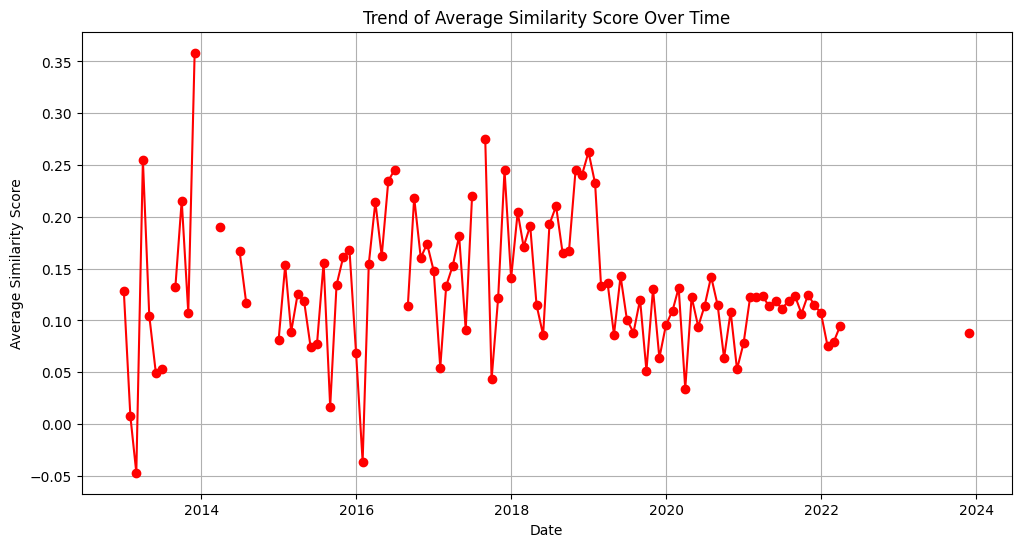

In [23]:


# ---- 6. Trend of Average Similarity Score Over Time ----
monthly_avg_sim = combined_df.groupby(pd.Grouper(key='date_published', freq='M'))['similarity_score'].mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_sim.index, monthly_avg_sim.values, marker="o", linestyle="-", color="red")
plt.title("Trend of Average Similarity Score Over Time")
plt.xlabel("Date")
plt.ylabel("Average Similarity Score")
plt.grid(True)
plt.show()

<ipython-input-34-7fa90d96ab1c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_locations.index, x=top_locations.values, palette="viridis")


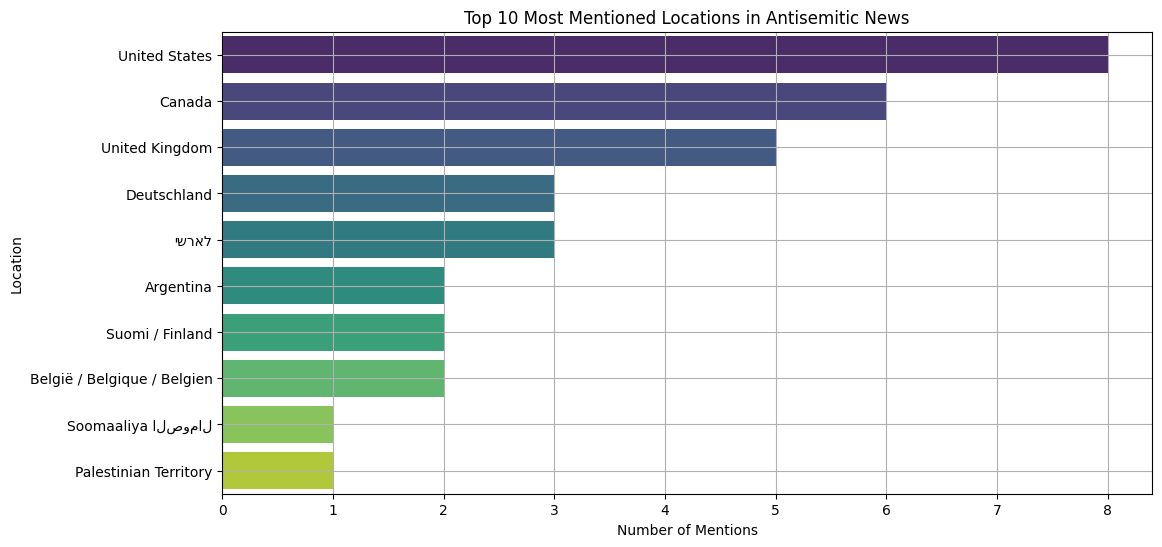

In [34]:
# Function to extract country from event_location
def extract_country(location):
    if pd.isna(location):
        return None
    return location.split(",")[-1].strip()  # Get the last part (Country)

# Apply the function to transform the column
top_related_df['event_location'] = top_related_df['event_location'].apply(extract_country)
top_locations = top_related_df['event_location'].dropna().value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(y=top_locations.index, x=top_locations.values, palette="viridis")
plt.title("Top 10 Most Mentioned Locations in Antisemitic News")
plt.xlabel("Number of Mentions")
plt.ylabel("Location")
plt.grid(True)
plt.show()